In [1]:
import pandas as pd
import numpy as np
import json
import re
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from deeppavlov import build_model, configs

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwords_nltk
stopwords_nltk = set(stopwords_nltk.words('english'))
from gensim.parsing.preprocessing import STOPWORDS as stopwords_gensim

import gensim
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim.corpora as corpora
from pprint import pprint

import os
from os.path import join

from tqdm.auto import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/stas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def compute_coherence_values(corpus, id2word, topics_range, rs):
    coherence_values = []

    for num_topics in tqdm(topics_range):        
        model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=rs)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

In [4]:
def lemmatize_stemming(text):
#     return SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(text, pos='v'))
#     return SnowballStemmer('english').stem(text)
    return WordNetLemmatizer().lemmatize(text, pos='v')

In [5]:
model = build_model(configs.morpho_tagger.UD2_0.morpho_en, download=True)

2021-12-01 02:02:27.976 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/datasets/UD2.0_source/en.tar.gz download because of matching hashes
2021-12-01 02:02:28.239 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/deeppavlov_data/morpho_tagger/UD2.0/en.tar.gz download because of matching hashes
[nltk_data] Downloading package punkt to /home/stas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/stas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/stas/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/stas/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
2021-12-01 02:02:28.268 INFO in 'deeppavlov.core.data.simple_vocab'['simpl

2021-12-01 02:02:29.750 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['morpho_tagger'] at line 166: 82 symbols, 119 tags in CharacterTagger
/home/stas/venvs/main/lib/python3.7/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)
2021-12-01 02:02:30.591 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 224: Model: "model"
2021-12-01 02:02:30.591 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 225: __________________________________________________________________________________________________
2021-12-01 02:02:30.592 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 222:  Layer (type)                   Output Shape         Param #     Connected to                     
2021-12-01 02:02:30.592 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 227: ==

2021-12-01 02:02:30.611 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 222:                                                                   'conv2d_6[0][0]']               
2021-12-01 02:02:30.612 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 306:                                                                                                   
2021-12-01 02:02:30.612 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 222:  lambda_1 (Lambda)              (None, None, 1100)   0           ['concatenate[0][0]']            
2021-12-01 02:02:30.613 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 306:                                                                                                   
2021-12-01 02:02:30.613 INFO in 'deeppavlov.models.morpho_tagger.morpho_tagger'['layer_utils'] at line 222:  highway (Highway)              (None, None, 1100)   2422200    

In [6]:
stop_words = stopwords_nltk | stopwords_gensim
stop_words |= set(['python', 'pycharm'])

In [7]:
data = pd.read_json('pycharm_issues.json', lines=True)
data.head()

,idReadable,created,summary,description,Affected versions
0,PY-22135,1483471995465,"""Parameter foo unfilled"": false positives for ...","I'm getting false ""Incorrect call argument"" in...",[2016.3]
1,PY-22143,1483528763930,Python Extract Superclass: Incorrect Order of ...,"When extracting superclasses, if extractions i...",[2016.3]
2,PY-22145,1483545972098,Inspection does not report 'Unresolved Referen...,If a variable is deleted using the `del` state...,[2016.2]
3,PY-22149,1483572086024,ipython notebook clear_output() not working,"Below code should print only once ""Hellow Worl...",[]
4,PY-22128,1483387969625,False negative: no error for round brackets in...,I believe it's rather a common typo to use rou...,[2017.1]


In [8]:
data2 = data[[('2020.2' in el) for el in data['Affected versions']]].dropna()
data3 = data[[('2020.3' in el) for el in data['Affected versions']]].dropna()
data2.shape, data3.shape

((624, 5), (518, 5))

In [9]:
def get_popular_themes(model, corpus):
    popularity_by_text = [max(el, key=lambda x: x[1]) for el in model.get_document_topics(corpus)]
    return [(model.id2word[id_word], score) for id_word, score in popularity_by_text]

In [10]:
def process_data(data: pd.DataFrame, rs):
    d = data.summary.tolist()
    data_by_words = [simple_preprocess(row, deacc=True) for row in d]
    data_by_words = [[lemmatize_stemming(word) for word in issue if word not in stop_words]for issue in data_by_words ]
    
    list(map(lambda i: data_by_words.pop(i), list([i for i, el in enumerate(map(len, data_by_words)) if el > 4000])))
    
    batch_size = 5
    nouns = []
    for i in trange(len(data_by_words)//batch_size + 1):
        batch = data_by_words[i*batch_size:(i+1)*batch_size]
        for parse in model(batch):
            nouns.append([])
            for el in parse.strip('\n').split('\n'):
                row = el.split('\t')
                if len(row)>2 and (row[2] in ('NOUN', 'VERV')):
                    nouns[-1].append(row[1])
        del batch
    
    id2word = corpora.Dictionary(nouns)
    # id2word.filter_extremes(no_below=10, no_above=0.05)
#     id2word.filter_extremes(no_below=2, no_above=0.5)
    texts = nouns
    corpus = [id2word.doc2bow(text) for text in texts]
    
    tfidf = TfidfModel(corpus, id2word=id2word)
    corpus_tfidf = tfidf[corpus]
    
    topics_range = range(2, 200, 20)
    u_mass = compute_coherence_values(corpus_tfidf, id2word, topics_range, 0)

    sns.set_theme(rc={"figure.figsize": (10, 5)})
    ax = sns.lineplot(x=topics_range, y=u_mass, label='zoom out')
    ax.set_title("ROC-AUC per user during model training")
    ax.set_ylabel("Average ROC-AUC per user")
    ax.set_xlabel("Iteration")
    
    topics_range = range(40, 80, 5)
    u_mass = compute_coherence_values(corpus_tfidf, id2word, topics_range, 0)

    sns.set_theme(rc={"figure.figsize": (10, 5)})
    ax = sns.lineplot(x=topics_range, y=u_mass, label='zoom in')
    ax.set_title("ROC-AUC per user during model training")
    ax.set_ylabel("Average ROC-AUC per user")
    ax.set_xlabel("Iteration")
    plt.show()
    
    num_topics = 50
    tfidf_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
                                             id2word=id2word,
                                             num_topics=num_topics,
                                             random_state=rs)


    topics = tfidf_model.show_topics(num_topics, 5, formatted=False)
    topics_names_only = [list(zip(*el[1]))[0] for el in topics]
    
    tfidf_coefs = sorted([(tfidf.id2word[el_id], el_coef) for el_id, el_coef in tfidf.idfs.items()], reverse=True)
    
    popular_themes = get_popular_themes(tfidf_model, corpus_tfidf)
    return topics_names_only, tfidf_coefs, popular_themes

  0%|          | 0/125 [00:00<?, ?it/s]

/home/stas/venvs/main/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

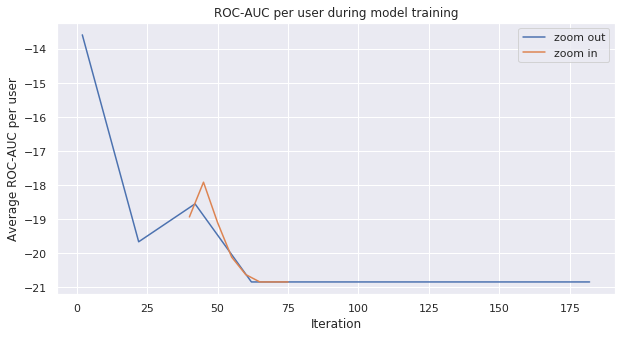

In [11]:
names2, tfidf_coefs2, popular_themes2 = process_data(data2, 0)

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

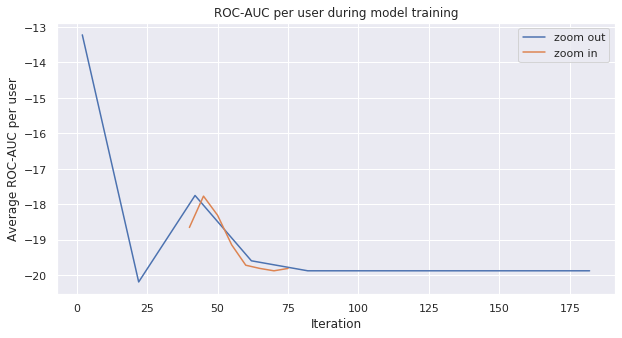

In [12]:
names3, tfidf_coefs3, popular_themes3 = process_data(data3, rs=0)

## Важное замечание
Я использую следующую терминологию:

"Документ" -- Текс, состоящий из предложений, в нашем issue 

"Топики" -- это набор "тем". "Темы" -- нормализованные слова из предложений документа

## Топики

Посмотрим на топики 2020.3 версии

In [13]:
names2

[('fish', 'setup', 'cells', 'framework', 'launch'),
 ('fish', 'setup', 'cells', 'framework', 'launch'),
 ('fish', 'setup', 'cells', 'framework', 'launch'),
 ('fish', 'setup', 'cells', 'framework', 'launch'),
 ('resolution', 'namespace', 'comment', 'py', 'package'),
 ('increase', 'number', 'raise', 'display', 'debug'),
 ('zoom', 'render', 'size', 'update', 'notebook'),
 ('members', 'declarations', 'cd', 'terminate', 'file'),
 ('fish', 'setup', 'cells', 'framework', 'launch'),
 ('sanity', 'installation', 'runtime', 'bug', 'check'),
 ('press', 'deployment', 'button', 'handle', 'time'),
 ('fish', 'setup', 'cells', 'framework', 'launch'),
 ('fish', 'setup', 'cells', 'framework', 'launch'),
 ('title', 'description', 'page', 'indentions', 'plugins'),
 ('bundle', 'restructure', 'inspect', 'violation', 'sh'),
 ('timeout', 'lang', 'restart', 'command', 'kernel'),
 ('app', 'miss', 'settings', 'py', 'line'),
 ('fish', 'setup', 'cells', 'framework', 'launch'),
 ('jinja', 'whitespace', 'raw', 'modif

Посмотрим на топики 2020.3 версии

In [14]:
names3

[('host', 'breakpoint', 'download', 'source', 'debug'),
 ('work', 'charm', 'coursor', 'appear', 'sir'),
 ('allow', 'default_factory', 'field', 'default', 'use'),
 ('deployment', 'configuration', 'depend', 'map', 'convert'),
 ('model', 'base', 'interpreter', 'wsl', 'auto'),
 ('enum', 'text', 'negative', 'literals', 'enums'),
 ('enum', 'text', 'negative', 'literals', 'enums'),
 ('build', 'home', 'permission', 'users', 'file'),
 ('subprocess', 'problem', 'text', 'detect', 'issue'),
 ('uml', 'profile', 'profiler', 'menu', 'fee'),
 ('analysis', 'syntax', 'break', 'docker', 'error'),
 ('enum', 'text', 'negative', 'literals', 'enums'),
 ('field', 'docker', 'succeed', 'task', 'make'),
 ('context', 'shift', 'ctrl', 'use', 'interpreter'),
 ('compose', 'service', 'specify', 'version', 'docker'),
 ('enum', 'text', 'negative', 'literals', 'enums'),
 ('oversimplify', 'enum', 'enums', 'literals', 'negative'),
 ('enum', 'text', 'negative', 'literals', 'enums'),
 ('pydevd_pycharm', 'port', 'settrace', 

## TFIDF компоненты

Оценим, не произошло ли значимых изменений в tfidf компонентах тем, которые перешли из 2020.2 релиза в 2020.3. Такие темы могут сигнализировать о конкретной проблеме. Сейчас значительных изменений не заметно

In [15]:
d2 = pd.DataFrame(tfidf_coefs2, columns=['theme', '2020.2']).groupby('theme').median()
d3 = pd.DataFrame(tfidf_coefs3, columns=['theme', '2020.3']).groupby('theme').median()
tfidf_coefs = pd.merge(d2,d3, left_index=True, right_index=True)
tfidf_coefs['change'] = tfidf_coefs['2020.3'] - tfidf_coefs['2020.2']
tfidf_coefs[abs(tfidf_coefs.change) > 1.55].sort_values('change')

,2020.2,2020.3,change
theme,,,
reset,9.285402,6.016808,-3.268594
user,9.285402,6.209453,-3.075949
column,9.285402,6.431846,-2.853556
folder,9.285402,6.694880,-2.590522
sciview,9.285402,6.694880,-2.590522
page,9.285402,7.016808,-2.268594
download,9.285402,7.016808,-2.268594
html,9.285402,7.016808,-2.268594
popup,9.285402,7.016808,-2.268594


Теперь посмотрим на темы, которые исчезли с переходом в версию 2020.3. 

In [16]:
top_themes = d2.loc[set(d2.index)-set(d3.index)].sort_values('2020.2', ascending=False)
[(el.Index, np.round(el._1, 2)) for el in top_themes[top_themes['2020.2'] >= top_themes['2020.2'].median()].itertuples()]

[('indices', 9.29),
 ('flake', 9.29),
 ('enter', 9.29),
 ('export', 9.29),
 ('repositories', 9.29),
 ('static', 9.29),
 ('ansi', 9.29),
 ('widget', 9.29),
 ('dialogue', 9.29),
 ('workers', 9.29),
 ('some_str', 9.29),
 ('simplify', 9.29),
 ('submenu', 9.29),
 ('skeleton', 9.29),
 ('psicell', 9.29),
 ('presence', 9.29),
 ('perform', 9.29),
 ('argparse', 9.29),
 ('cached_property', 9.29),
 ('splash', 9.29),
 ('gpu', 9.29),
 ('drag', 9.29),
 ('occurences', 9.29),
 ('datetime', 9.29),
 ('mistake', 9.29),
 ('integer', 9.29),
 ('apostrophes', 9.29),
 ('press', 9.29),
 ('iteration', 9.29),
 ('bash_profile', 9.29),
 ('cyrillic', 9.29),
 ('track', 9.29),
 ('startup', 9.29),
 ('subclass', 9.29),
 ('atexit', 9.29),
 ('ordereddict', 9.29),
 ('race', 9.29),
 ('suppress', 9.29),
 ('valueerror', 9.29),
 ('redeclaration', 9.29),
 ('alt', 9.29),
 ('reorder', 9.29),
 ('syntaxerror', 9.29),
 ('getter', 9.29),
 ('debuggee', 9.29),
 ('rasberry', 9.29),
 ('float', 9.29),
 ('cimport', 9.29),
 ('overwrite', 9.

И темы, которые появились в 2020.3. 

In [17]:
top_themes = d3.loc[set(d3.index)-set(d2.index)].sort_values('2020.3', ascending=False)
[(el.Index, np.round(el._1, 2)) for el in top_themes[top_themes['2020.3'] >= top_themes['2020.3'].median()].itertuples()]

[('resource', 9.02),
 ('distutils', 9.02),
 ('dask', 9.02),
 ('form', 9.02),
 ('interpunct', 9.02),
 ('mobi', 9.02),
 ('catalina', 9.02),
 ('implementation', 9.02),
 ('priority', 9.02),
 ('sum', 9.02),
 ('ceil', 9.02),
 ('configs', 9.02),
 ('persist', 9.02),
 ('make', 9.02),
 ('winreg', 9.02),
 ('gray', 9.02),
 ('tokens', 9.02),
 ('rebuild', 9.02),
 ('positives', 9.02),
 ('treat', 9.02),
 ('rebase', 9.02),
 ('api', 9.02),
 ('circumstances', 9.02),
 ('settrace', 9.02),
 ('violate', 9.02),
 ('place', 9.02),
 ('circuit', 9.02),
 ('stuff', 9.02),
 ('increments', 9.02),
 ('itertools', 9.02),
 ('fragment', 9.02),
 ('succeed', 9.02),
 ('argumentparser', 9.02),
 ('repr', 9.02),
 ('poetry', 9.02),
 ('port', 9.02),
 ('jupiter', 9.02),
 ('pydevd_pycharm', 9.02),
 ('metrics', 9.02),
 ('usr', 9.02),
 ('noreturn', 9.02),
 ('deconstruct', 9.02),
 ('sync', 9.02),
 ('management', 9.02),
 ('toctree', 9.02),
 ('gitignore', 9.02),
 ('enums', 9.02),
 ('hyperlinks', 9.02),
 ('pool', 9.02),
 ('party', 9.02),

Теперь посмотрим на темы в разрезе ``популярности``, то есть того, насколько выраженны темы в топкиках.
Опять начнем с тем, которые перешли из релиза в релиз

In [18]:
d2 = pd.DataFrame(popular_themes2, columns=['theme', '2020.2']).groupby('theme').median()
d3 = pd.DataFrame(popular_themes3, columns=['theme', '2020.3']).groupby('theme').median()
popular_themes = pd.merge(d2,d3, left_index=True, right_index=True)
popular_themes['change'] = popular_themes['2020.3'] - popular_themes['2020.2']
popular_themes.sort_values('change')

,2020.2,2020.3,change
theme,,,
string,0.354586,0.294982,-0.059603
code,0.350254,0.324829,-0.025425


Посмотрим на те, которые исчезли с переходом на 2020.3

In [19]:
d2.loc[set(d2.index)-set(d3.index)].sort_values('2020.2', ascending=False).head(15)

,2020.2
theme,
runserver,0.436379
exception,0.390251
directory,0.377833
container,0.375369
manage,0.365305
django,0.345959
module,0.340690
submodule,0.336455
template,0.335711


In [20]:
d3.loc[set(d3.index)-set(d2.index)].sort_values('2020.3', ascending=False).head(15)

,2020.3
theme,
leak,0.586603
analysis,0.441405
wierd,0.434798
raise,0.392737
lang,0.374076
annotations,0.356331
subprocesses,0.354571
cumbersome,0.350738
window,0.350107
